# Early Oscillation: What's Causing the Sawtooth?

In the first ~40 steps of training, dead token displacement shows a decaying oscillation pattern—not smooth decay, but a sawtooth: drop-drop-rise-drop-drop-rise.

**Question:** What's oscillating? Is it:
- The raw gradients themselves?
- The momentum accumulation?
- The variance accumulation?
- The ratio m/√v?
- Some interaction between them?

We zoom in on steps 1-40 and plot all the independently varying quantities.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

# Paths
PROJECT_ROOT = Path.cwd().parent.parent.parent
CRUCIBLE_2_PATH = PROJECT_ROOT / 'box_4' / 'tensors' / 'Crucible-2' / 'crucible_2_trajectory.safetensors'

# AdamW hyperparameters
BETA1 = 0.9
BETA2 = 0.999
EPS = 1e-8
LR = 1e-3

# Style
plt.rcParams['figure.dpi'] = 150
STEELBLUE = '#4682B4'

# How many steps to examine
N_STEPS = 40

print(f"Examining first {N_STEPS} steps")

Examining first 40 steps


In [2]:
# Load Crucible 2 trajectory data
tensors = load_file(CRUCIBLE_2_PATH)

# We have:
# - g: [500, 3699, 64] raw gradients at each step
# - m: [501, 3699, 64] momentum AFTER each step (m[0] = initial = 0)
# - v: [501, 3699, 64] variance AFTER each step (v[0] = initial = 0)
# - delta_W_prime: [500, 3699, 64] lattice displacement at each step

g = tensors['g'][:N_STEPS]  # [40, 3699, 64]
m = tensors['m'][:N_STEPS+1]  # [41, 3699, 64] - includes initial state
v = tensors['v'][:N_STEPS+1]  # [41, 3699, 64]
delta_W_prime = tensors['delta_W_prime'][:N_STEPS]  # [40, 3699, 64]

n_tokens = g.shape[1]
n_dims = g.shape[2]

print(f"Loaded data for {N_STEPS} steps, {n_tokens} dead tokens, {n_dims} dims")

Loaded data for 40 steps, 3699 dead tokens, 64 dims


In [3]:
# Compute all the quantities we want to track

steps = np.arange(1, N_STEPS + 1)

# 1. Mean |ΔW′| - the displacement we're trying to explain
disp_l2 = delta_W_prime.norm(dim=2)  # [40, 3699]
disp_l2 = torch.where(torch.isfinite(disp_l2), disp_l2, torch.zeros_like(disp_l2))
mean_disp = disp_l2.mean(dim=1).numpy()  # [40]

# 2. Mean |g| - raw gradient magnitude
g_l2 = g.norm(dim=2)  # [40, 3699]
mean_g = g_l2.mean(dim=1).numpy()  # [40]

# 3. Mean |m| - raw momentum magnitude (AFTER the step, so m[1:N_STEPS+1])
m_l2 = m[1:].norm(dim=2)  # [40, 3699]
mean_m = m_l2.mean(dim=1).numpy()  # [40]

# 4. Mean √v - raw variance magnitude
sqrt_v = torch.sqrt(v[1:])  # [40, 3699, 64]
sqrt_v_l2 = sqrt_v.norm(dim=2)  # [40, 3699]
mean_sqrt_v = sqrt_v_l2.mean(dim=1).numpy()  # [40]

# 5. Bias correction factors
t = torch.arange(1, N_STEPS + 1).float()
bias_corr_1 = (1 - BETA1 ** t).numpy()  # [40]
bias_corr_2 = (1 - BETA2 ** t).numpy()  # [40]

# 6. Bias-corrected quantities
# m̂ = m / (1 - β₁^t)
m_hat = m[1:] / (1 - BETA1 ** t).view(-1, 1, 1)  # [40, 3699, 64]
m_hat_l2 = m_hat.norm(dim=2)  # [40, 3699]
mean_m_hat = m_hat_l2.mean(dim=1).numpy()  # [40]

# √v̂ = √(v / (1 - β₂^t))
v_hat = v[1:] / (1 - BETA2 ** t).view(-1, 1, 1)  # [40, 3699, 64]
sqrt_v_hat = torch.sqrt(v_hat)  # [40, 3699, 64]
sqrt_v_hat_l2 = sqrt_v_hat.norm(dim=2)  # [40, 3699]
mean_sqrt_v_hat = sqrt_v_hat_l2.mean(dim=1).numpy()  # [40]

# 7. The ratio m̂ / (√v̂ + ε) - this is the actual update direction/magnitude before lr
ratio = m_hat / (sqrt_v_hat + EPS)  # [40, 3699, 64]
ratio_l2 = ratio.norm(dim=2)  # [40, 3699]
mean_ratio = ratio_l2.mean(dim=1).numpy()  # [40]

print("Computed all metrics.")

Computed all metrics.


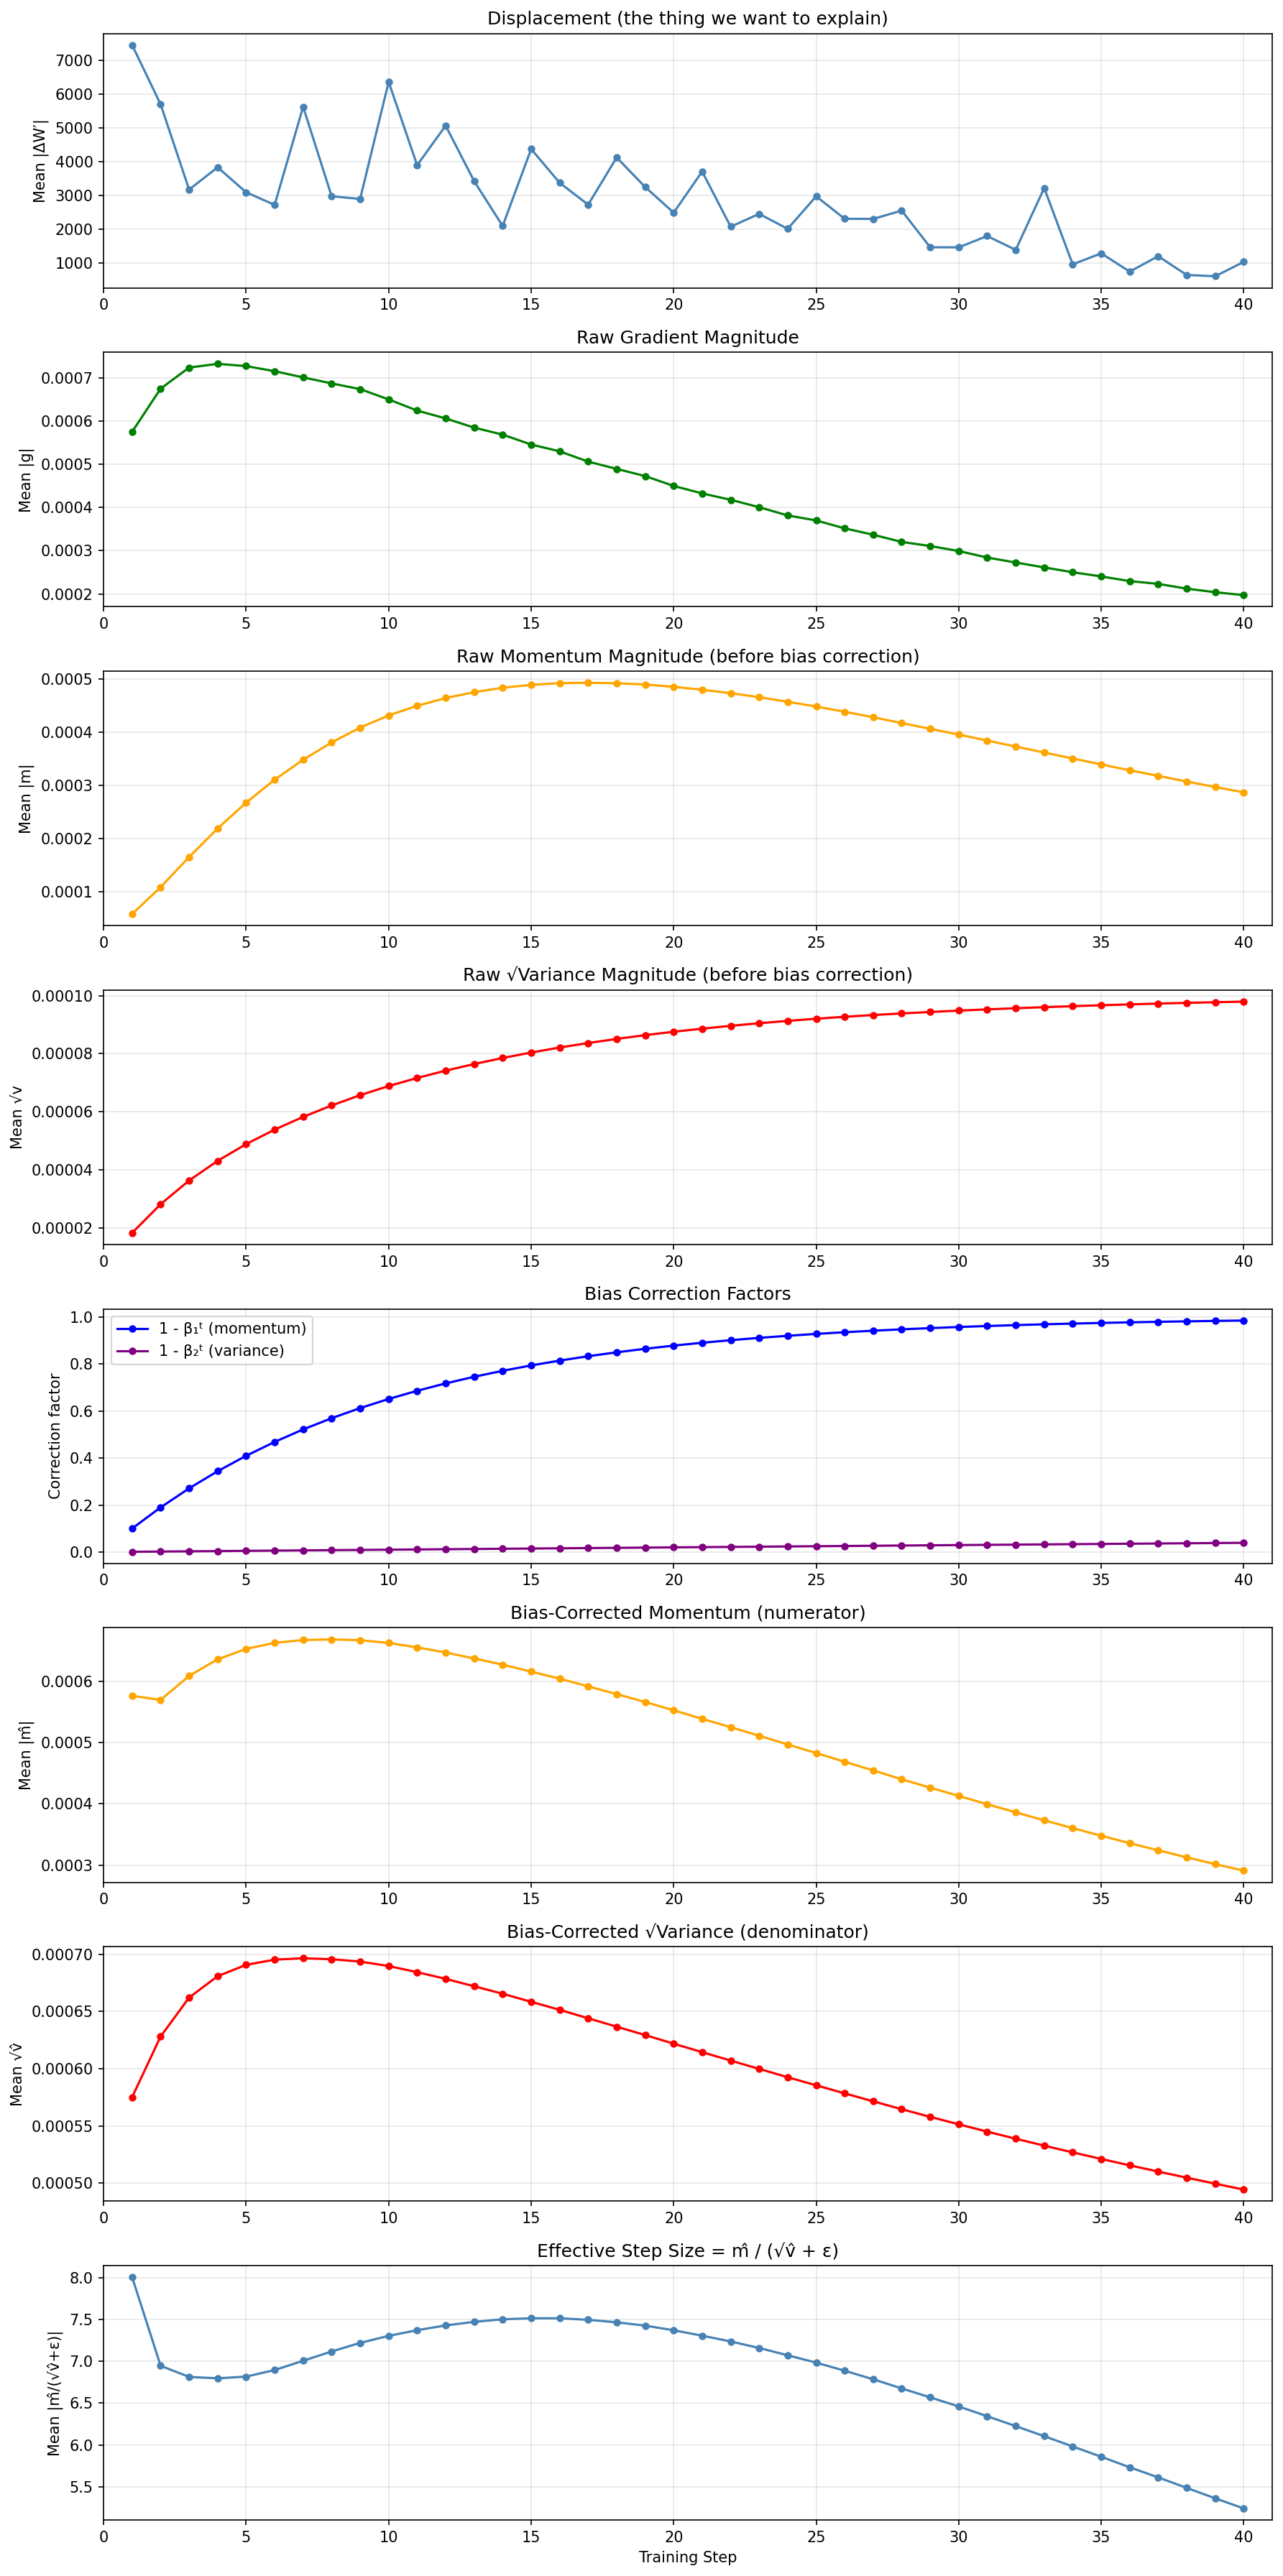

In [4]:
# Plot everything in a vertical stack
fig, axes = plt.subplots(8, 1, figsize=(12, 24))

# 1. Displacement (what we're explaining)
ax = axes[0]
ax.plot(steps, mean_disp, 'o-', color=STEELBLUE, markersize=4)
ax.set_ylabel('Mean |ΔW′|')
ax.set_title('Displacement (the thing we want to explain)')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, N_STEPS + 1)

# 2. Raw gradient
ax = axes[1]
ax.plot(steps, mean_g, 'o-', color='green', markersize=4)
ax.set_ylabel('Mean |g|')
ax.set_title('Raw Gradient Magnitude')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, N_STEPS + 1)

# 3. Raw momentum
ax = axes[2]
ax.plot(steps, mean_m, 'o-', color='orange', markersize=4)
ax.set_ylabel('Mean |m|')
ax.set_title('Raw Momentum Magnitude (before bias correction)')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, N_STEPS + 1)

# 4. Raw √variance
ax = axes[3]
ax.plot(steps, mean_sqrt_v, 'o-', color='red', markersize=4)
ax.set_ylabel('Mean √v')
ax.set_title('Raw √Variance Magnitude (before bias correction)')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, N_STEPS + 1)

# 5. Bias correction factors
ax = axes[4]
ax.plot(steps, bias_corr_1, 'o-', color='blue', markersize=4, label='1 - β₁ᵗ (momentum)')
ax.plot(steps, bias_corr_2, 'o-', color='purple', markersize=4, label='1 - β₂ᵗ (variance)')
ax.set_ylabel('Correction factor')
ax.set_title('Bias Correction Factors')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, N_STEPS + 1)

# 6. Bias-corrected momentum
ax = axes[5]
ax.plot(steps, mean_m_hat, 'o-', color='orange', markersize=4)
ax.set_ylabel('Mean |m̂|')
ax.set_title('Bias-Corrected Momentum (numerator)')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, N_STEPS + 1)

# 7. Bias-corrected √variance
ax = axes[6]
ax.plot(steps, mean_sqrt_v_hat, 'o-', color='red', markersize=4)
ax.set_ylabel('Mean √v̂')
ax.set_title('Bias-Corrected √Variance (denominator)')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, N_STEPS + 1)

# 8. The ratio (should track displacement!)
ax = axes[7]
ax.plot(steps, mean_ratio, 'o-', color=STEELBLUE, markersize=4)
ax.set_ylabel('Mean |m̂/(√v̂+ε)|')
ax.set_title('Effective Step Size = m̂ / (√v̂ + ε)')
ax.set_xlabel('Training Step')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, N_STEPS + 1)

plt.tight_layout()
plt.show()

## Direct Comparison: Displacement vs Ratio

If Adam is working correctly, the displacement should be proportional to the ratio m̂/(√v̂+ε). Let's overlay them.

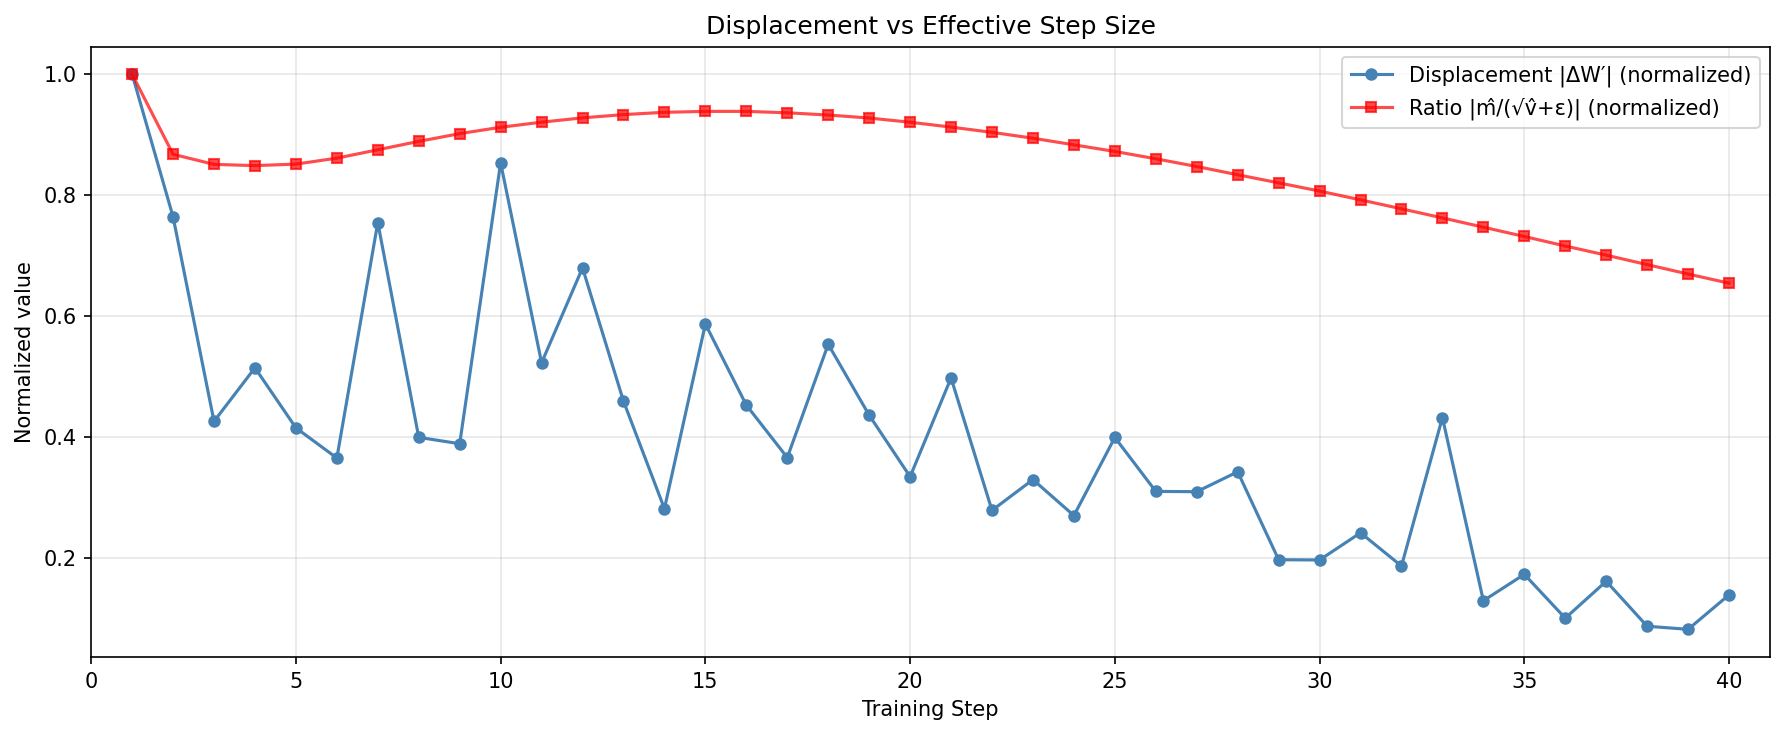

Correlation between displacement and ratio: 0.7068


In [5]:
fig, ax = plt.subplots(figsize=(12, 5))

# Normalize both to their max for comparison
disp_norm = mean_disp / mean_disp.max()
ratio_norm = mean_ratio / mean_ratio.max()

ax.plot(steps, disp_norm, 'o-', color=STEELBLUE, markersize=5, label='Displacement |ΔW′| (normalized)')
ax.plot(steps, ratio_norm, 's-', color='red', markersize=5, alpha=0.7, label='Ratio |m̂/(√v̂+ε)| (normalized)')

ax.set_xlabel('Training Step')
ax.set_ylabel('Normalized value')
ax.set_title('Displacement vs Effective Step Size')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, N_STEPS + 1)

plt.tight_layout()
plt.show()

# Correlation
corr = np.corrcoef(mean_disp, mean_ratio)[0, 1]
print(f"Correlation between displacement and ratio: {corr:.4f}")

## Decomposing the Oscillation

The ratio is m̂/(√v̂+ε). Let's see which component is oscillating more.

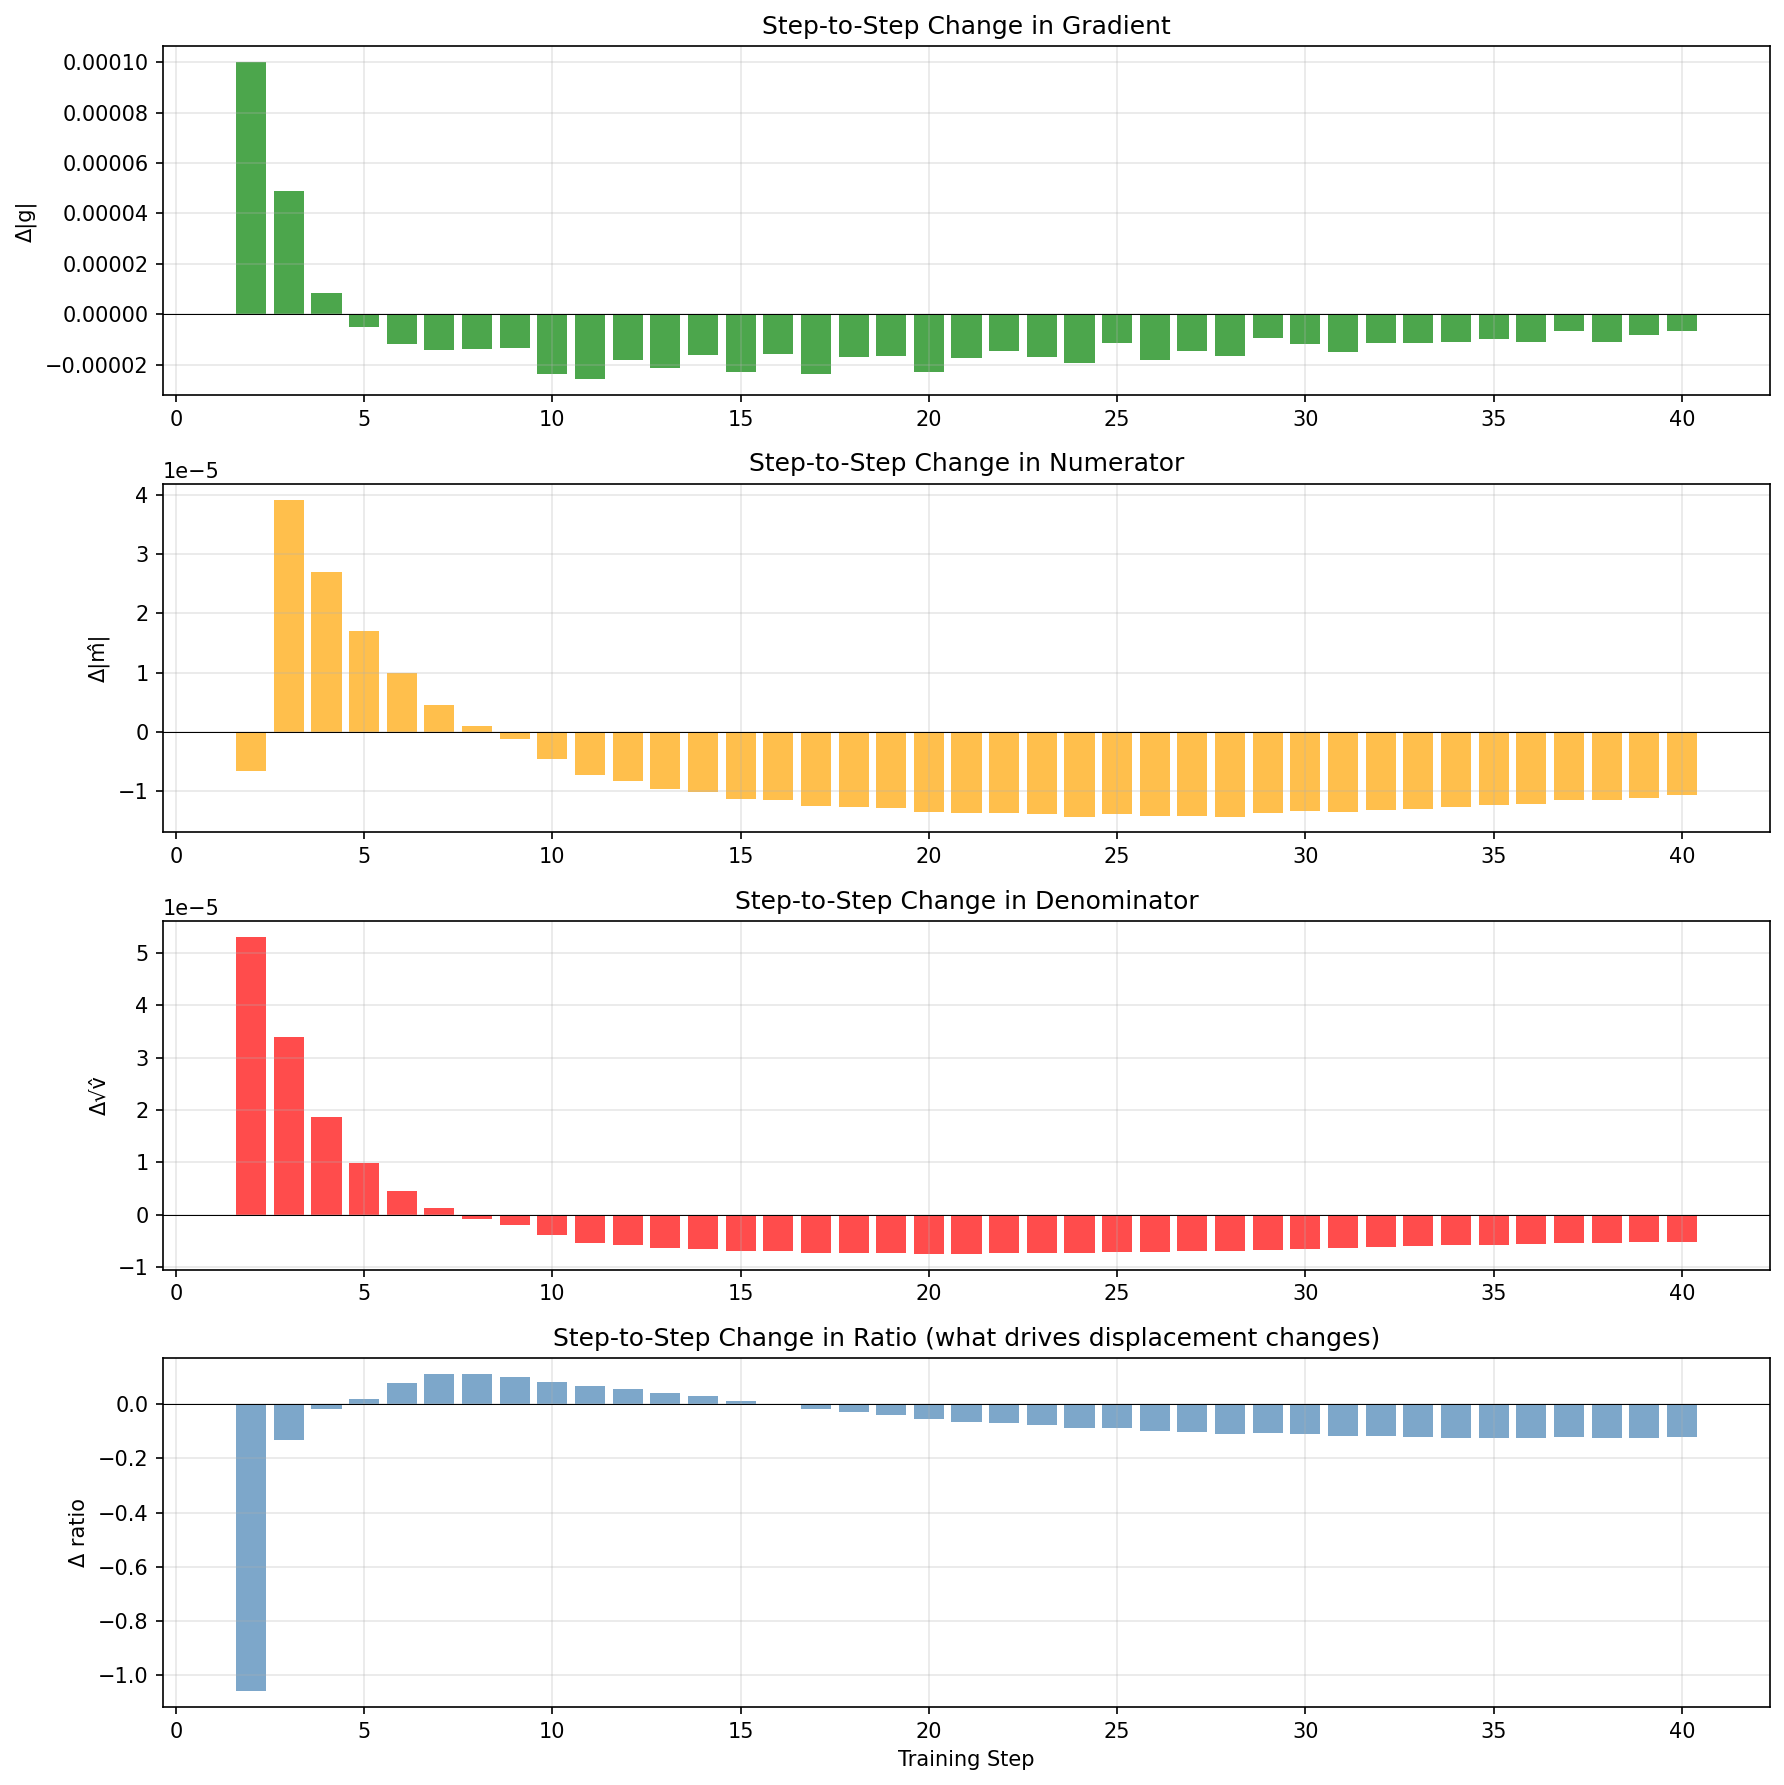

In [6]:
# Compute step-to-step changes
delta_m_hat = np.diff(mean_m_hat)
delta_sqrt_v_hat = np.diff(mean_sqrt_v_hat)
delta_ratio = np.diff(mean_ratio)
delta_g = np.diff(mean_g)

fig, axes = plt.subplots(4, 1, figsize=(12, 12))

steps_diff = steps[1:]  # steps 2-40

# Change in gradient
ax = axes[0]
ax.bar(steps_diff, delta_g, color='green', alpha=0.7)
ax.axhline(0, color='black', linewidth=0.5)
ax.set_ylabel('Δ|g|')
ax.set_title('Step-to-Step Change in Gradient')
ax.grid(True, alpha=0.3)

# Change in numerator
ax = axes[1]
ax.bar(steps_diff, delta_m_hat, color='orange', alpha=0.7)
ax.axhline(0, color='black', linewidth=0.5)
ax.set_ylabel('Δ|m̂|')
ax.set_title('Step-to-Step Change in Numerator')
ax.grid(True, alpha=0.3)

# Change in denominator
ax = axes[2]
ax.bar(steps_diff, delta_sqrt_v_hat, color='red', alpha=0.7)
ax.axhline(0, color='black', linewidth=0.5)
ax.set_ylabel('Δ√v̂')
ax.set_title('Step-to-Step Change in Denominator')
ax.grid(True, alpha=0.3)

# Change in ratio
ax = axes[3]
ax.bar(steps_diff, delta_ratio, color=STEELBLUE, alpha=0.7)
ax.axhline(0, color='black', linewidth=0.5)
ax.set_ylabel('Δ ratio')
ax.set_title('Step-to-Step Change in Ratio (what drives displacement changes)')
ax.set_xlabel('Training Step')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Is It Just the Gradients?

Maybe the oscillation is baked into the gradient signal itself, and Adam is just faithfully transmitting it.

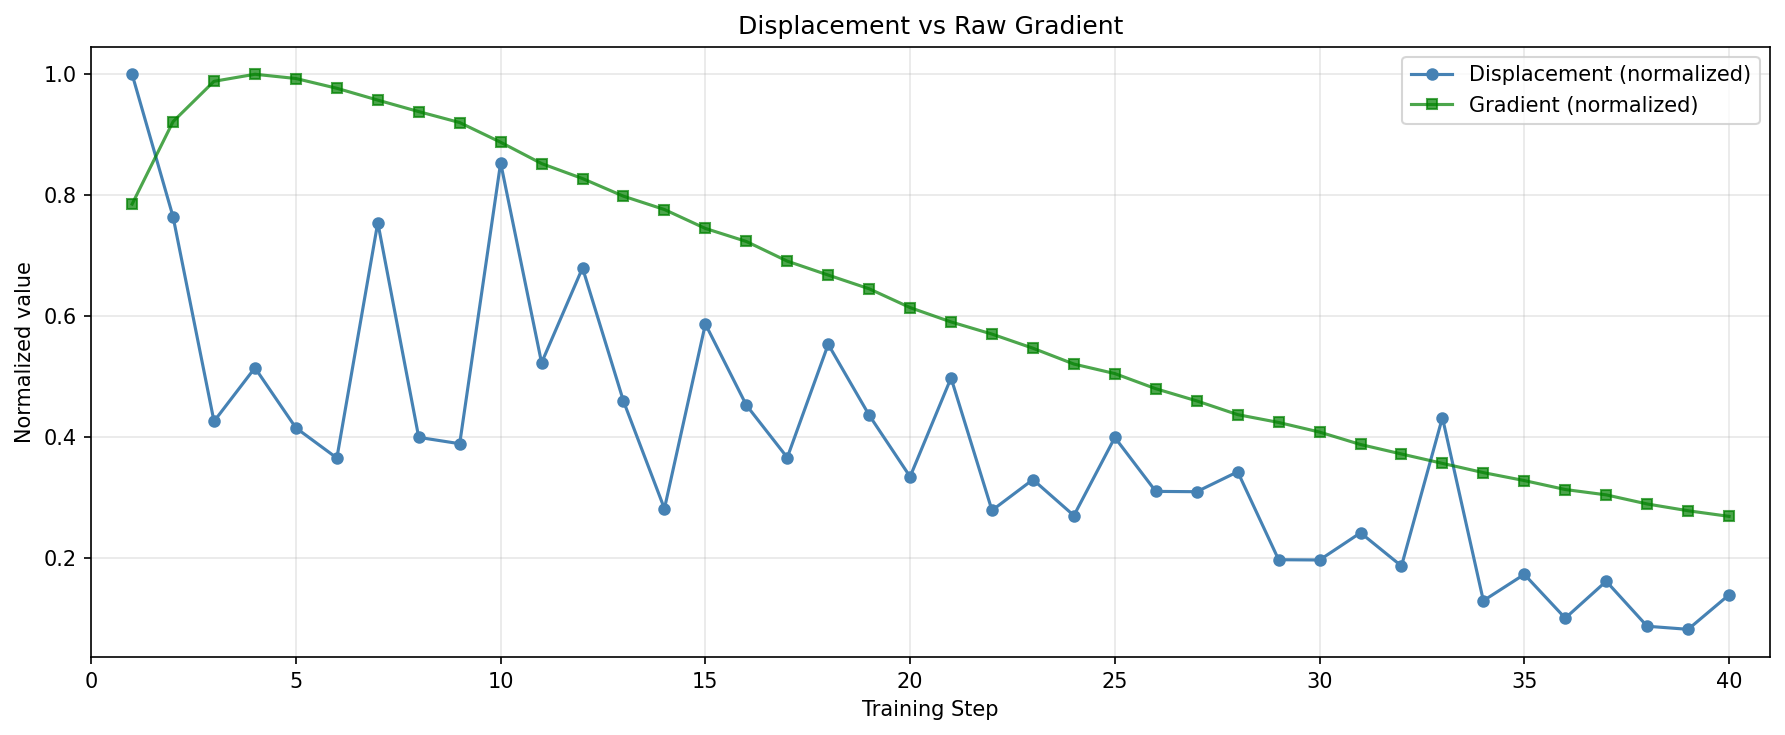

Correlation between displacement and gradient: 0.7136


In [7]:
fig, ax = plt.subplots(figsize=(12, 5))

# Normalize for comparison
g_norm = mean_g / mean_g.max()

ax.plot(steps, disp_norm, 'o-', color=STEELBLUE, markersize=5, label='Displacement (normalized)')
ax.plot(steps, g_norm, 's-', color='green', markersize=5, alpha=0.7, label='Gradient (normalized)')

ax.set_xlabel('Training Step')
ax.set_ylabel('Normalized value')
ax.set_title('Displacement vs Raw Gradient')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, N_STEPS + 1)

plt.tight_layout()
plt.show()

corr_g = np.corrcoef(mean_disp, mean_g)[0, 1]
print(f"Correlation between displacement and gradient: {corr_g:.4f}")

Per-token correlation at step 1: -0.0108


/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_50281/1996169230.py:26: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(token_ratio, token_disp, 1)


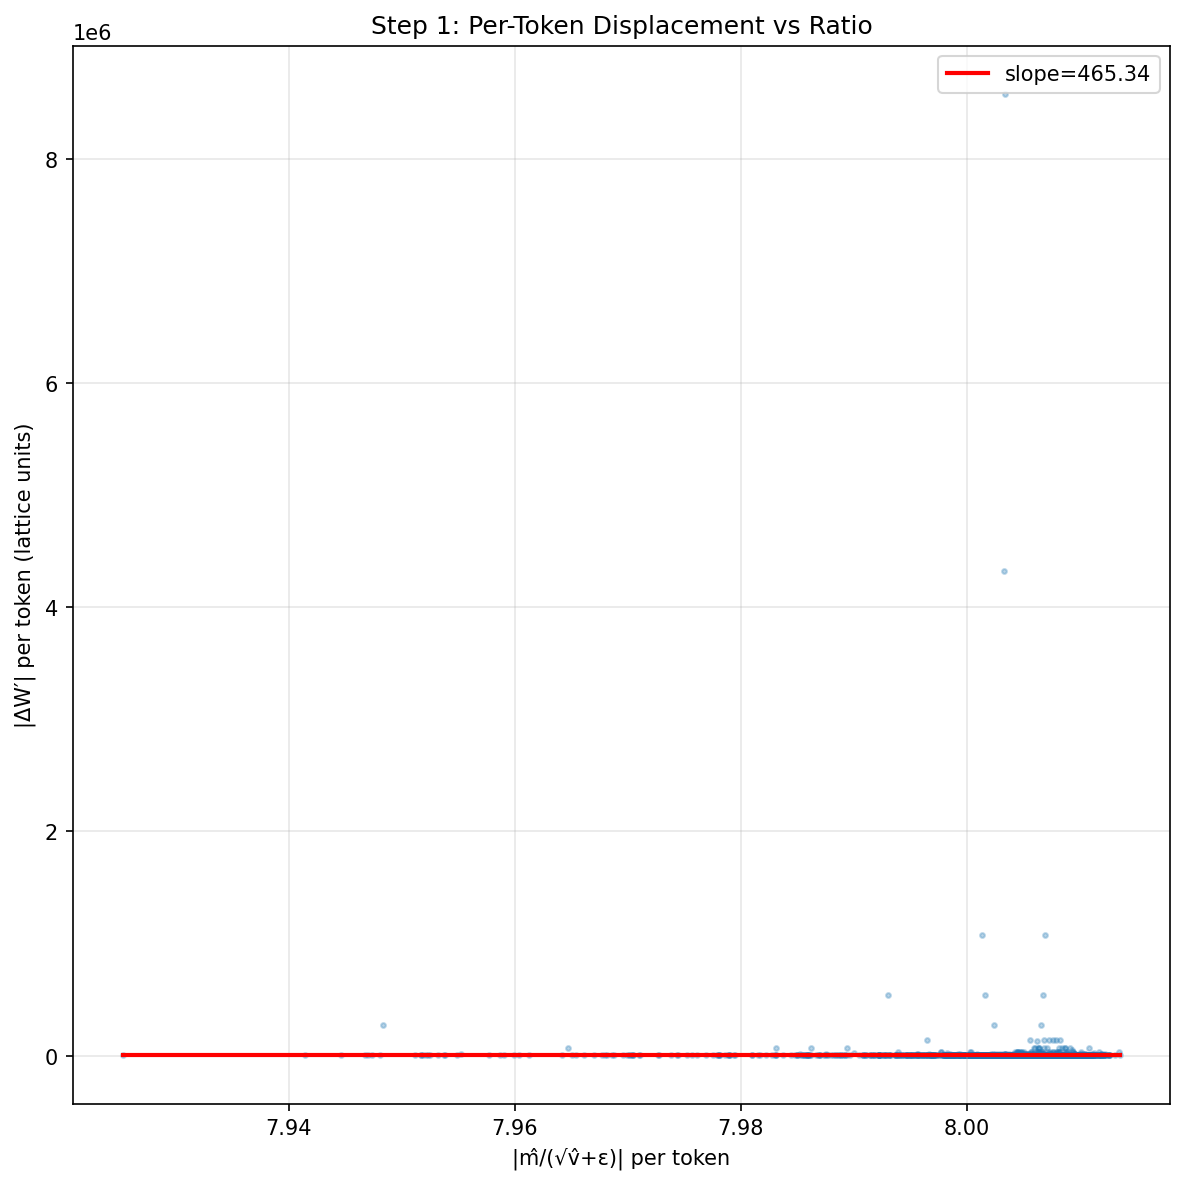

In [8]:
# Sanity check: Does ΔW′ actually equal lr × m̂/(√v̂+ε)?
# The lattice displacement ΔW′ is measured in ULP, not weight space.
# So there's a quantization step between the continuous Adam update and what we measure.

# Let's check the L2 norms' correlation at the per-token level
# Pick step 1 as an example
step_idx = 0

# Per-token L2 norms at step 1
token_disp = disp_l2[step_idx].numpy()  # [3699]
token_ratio = ratio_l2[step_idx].numpy()  # [3699]

# Scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(token_ratio, token_disp, alpha=0.3, s=5)
ax.set_xlabel('|m̂/(√v̂+ε)| per token')
ax.set_ylabel('|ΔW′| per token (lattice units)')
ax.set_title(f'Step 1: Per-Token Displacement vs Ratio')
ax.grid(True, alpha=0.3)

# Correlation
token_corr = np.corrcoef(token_disp, token_ratio)[0, 1]
print(f"Per-token correlation at step 1: {token_corr:.4f}")

# Add regression line
coef = np.polyfit(token_ratio, token_disp, 1)
x_line = np.linspace(token_ratio.min(), token_ratio.max(), 100)
y_line = coef[0] * x_line + coef[1]
ax.plot(x_line, y_line, 'r-', linewidth=2, label=f'slope={coef[0]:.2f}')
ax.legend()

plt.tight_layout()
plt.show()

In [9]:
# AHA! The near-zero correlation makes sense!
# At step 1, due to Adam's bias correction cancellation:
#   ratio = m̂/(√v̂+ε) ≈ g/|g| = sign(g)
# 
# So |ratio| ≈ √D for every token (since each dimension contributes ±1).
# Everyone has the same effective step size in weight space!
#
# But ΔW′ is measured in LATTICE UNITS (ULP), which vary by position.
# Tokens at different weight magnitudes have different ULP sizes.
# So even though they all move ~lr in weight space, they move DIFFERENT
# amounts in lattice space.

# Let's verify: at step 1, all tokens should have similar ratio magnitudes
print(f"Step 1 ratio L2 stats:")
print(f"  Mean: {token_ratio.mean():.4f}")
print(f"  Std:  {token_ratio.std():.4f}")
print(f"  Min:  {token_ratio.min():.4f}")
print(f"  Max:  {token_ratio.max():.4f}")
print(f"  Expected (√64): {np.sqrt(64):.4f}")

# And the displacement should have much more variance (due to lattice effects)
print(f"\nStep 1 displacement L2 stats:")
print(f"  Mean: {token_disp.mean():.4f}")
print(f"  Std:  {token_disp.std():.4f}")
print(f"  Min:  {token_disp.min():.4f}")
print(f"  Max:  {token_disp.max():.4f}")

Step 1 ratio L2 stats:
  Mean: 8.0048
  Std:  0.0070
  Min:  7.9253
  Max:  8.0136
  Expected (√64): 8.0000

Step 1 displacement L2 stats:
  Mean: 7450.7285
  Std:  161028.8125
  Min:  172.5290
  Max:  8585071.0000


Log-log correlation between |W|₂ and |ΔW′|₂: -0.0803
(Expected: around -1 if ΔW′ ∝ 1/|W|)


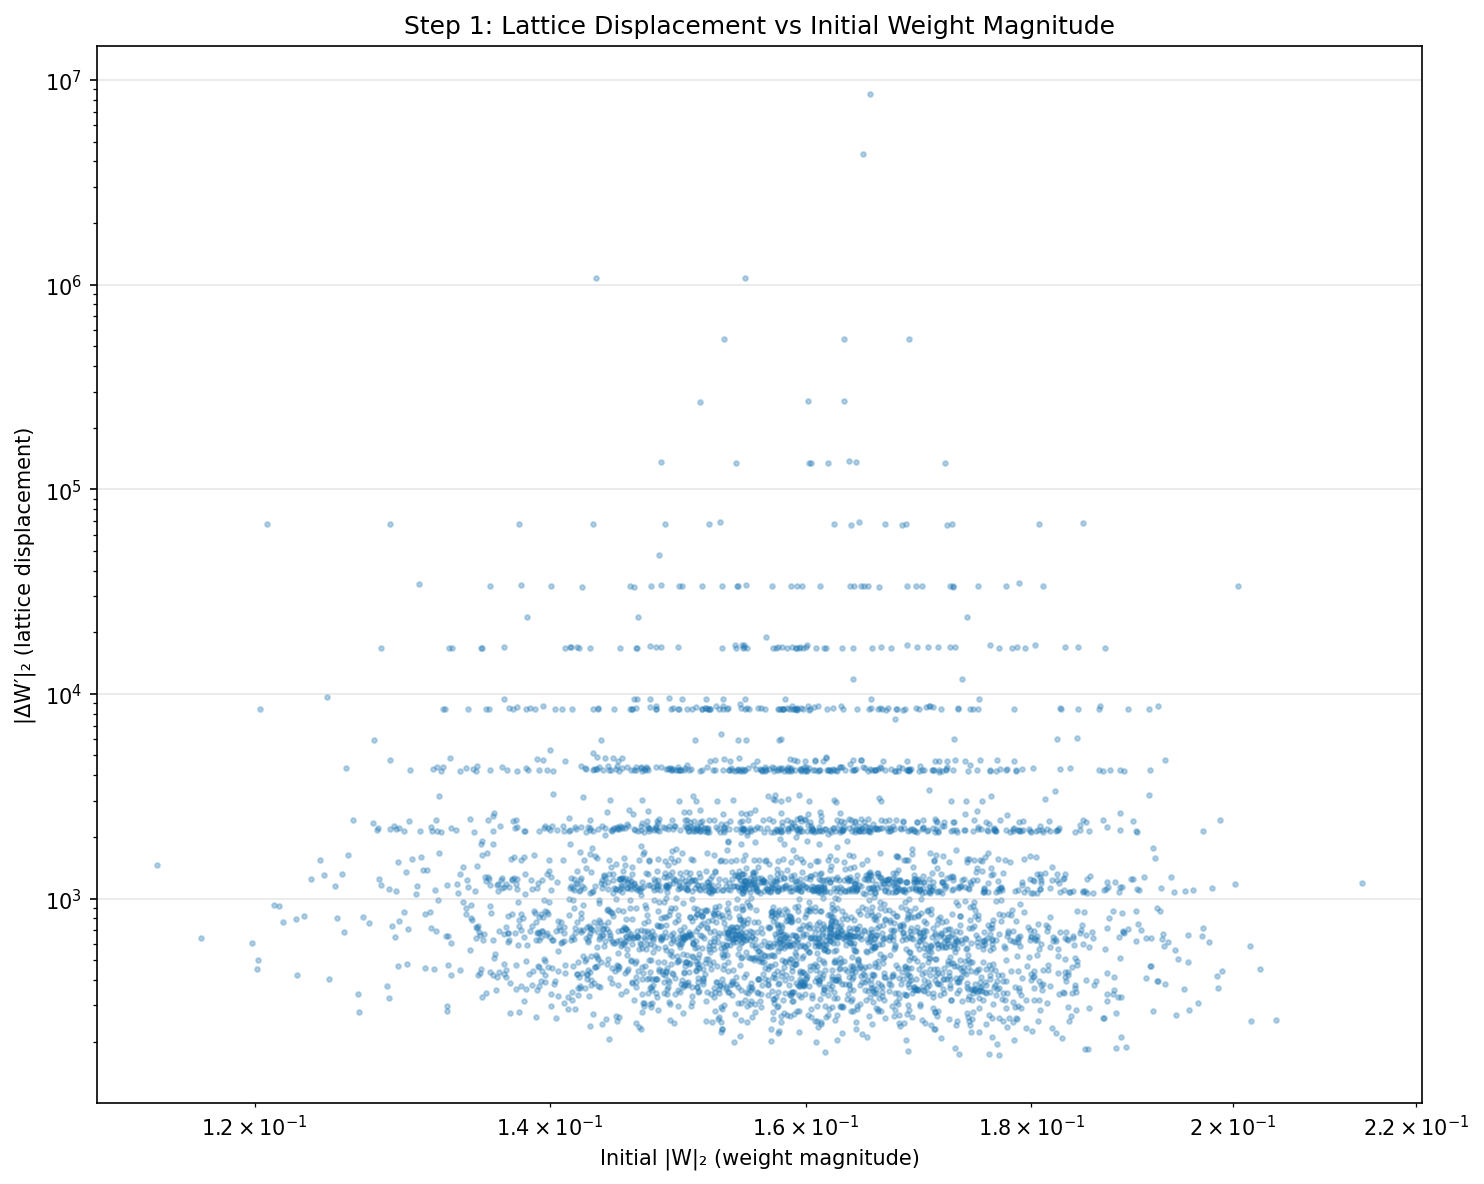

In [10]:
# The key insight: displacement in lattice units depends on weight magnitude,
# not on Adam's ratio!
#
# ULP ∝ |W| for bfloat16 (roughly)
# So ΔW′ = ΔW / ULP ∝ ΔW / |W|
#
# At step 1, ΔW ≈ constant for all tokens
# Therefore ΔW′ ∝ 1/|W|

# Let's load the initial weights and check
W_uint16 = tensors['W']  # [501, 3699, 64] as uint16 bitpattern
W = W_uint16.view(torch.bfloat16).float()
W_0 = W[0]  # Initial weights [3699, 64]

# Per-token L2 norm of initial weights
W_0_l2 = W_0.norm(dim=1).numpy()  # [3699]

# Scatter: initial weight magnitude vs displacement
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(W_0_l2, token_disp, alpha=0.3, s=5)
ax.set_xlabel('Initial |W|₂ (weight magnitude)')
ax.set_ylabel('|ΔW′|₂ (lattice displacement)')
ax.set_title('Step 1: Lattice Displacement vs Initial Weight Magnitude')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Correlation (in log space, since we expect inverse relationship)
log_corr = np.corrcoef(np.log(W_0_l2), np.log(token_disp))[0, 1]
print(f"Log-log correlation between |W|₂ and |ΔW′|₂: {log_corr:.4f}")
print(f"(Expected: around -1 if ΔW′ ∝ 1/|W|)")

plt.tight_layout()
plt.show()

Log-log correlation (dim 0): -0.9841


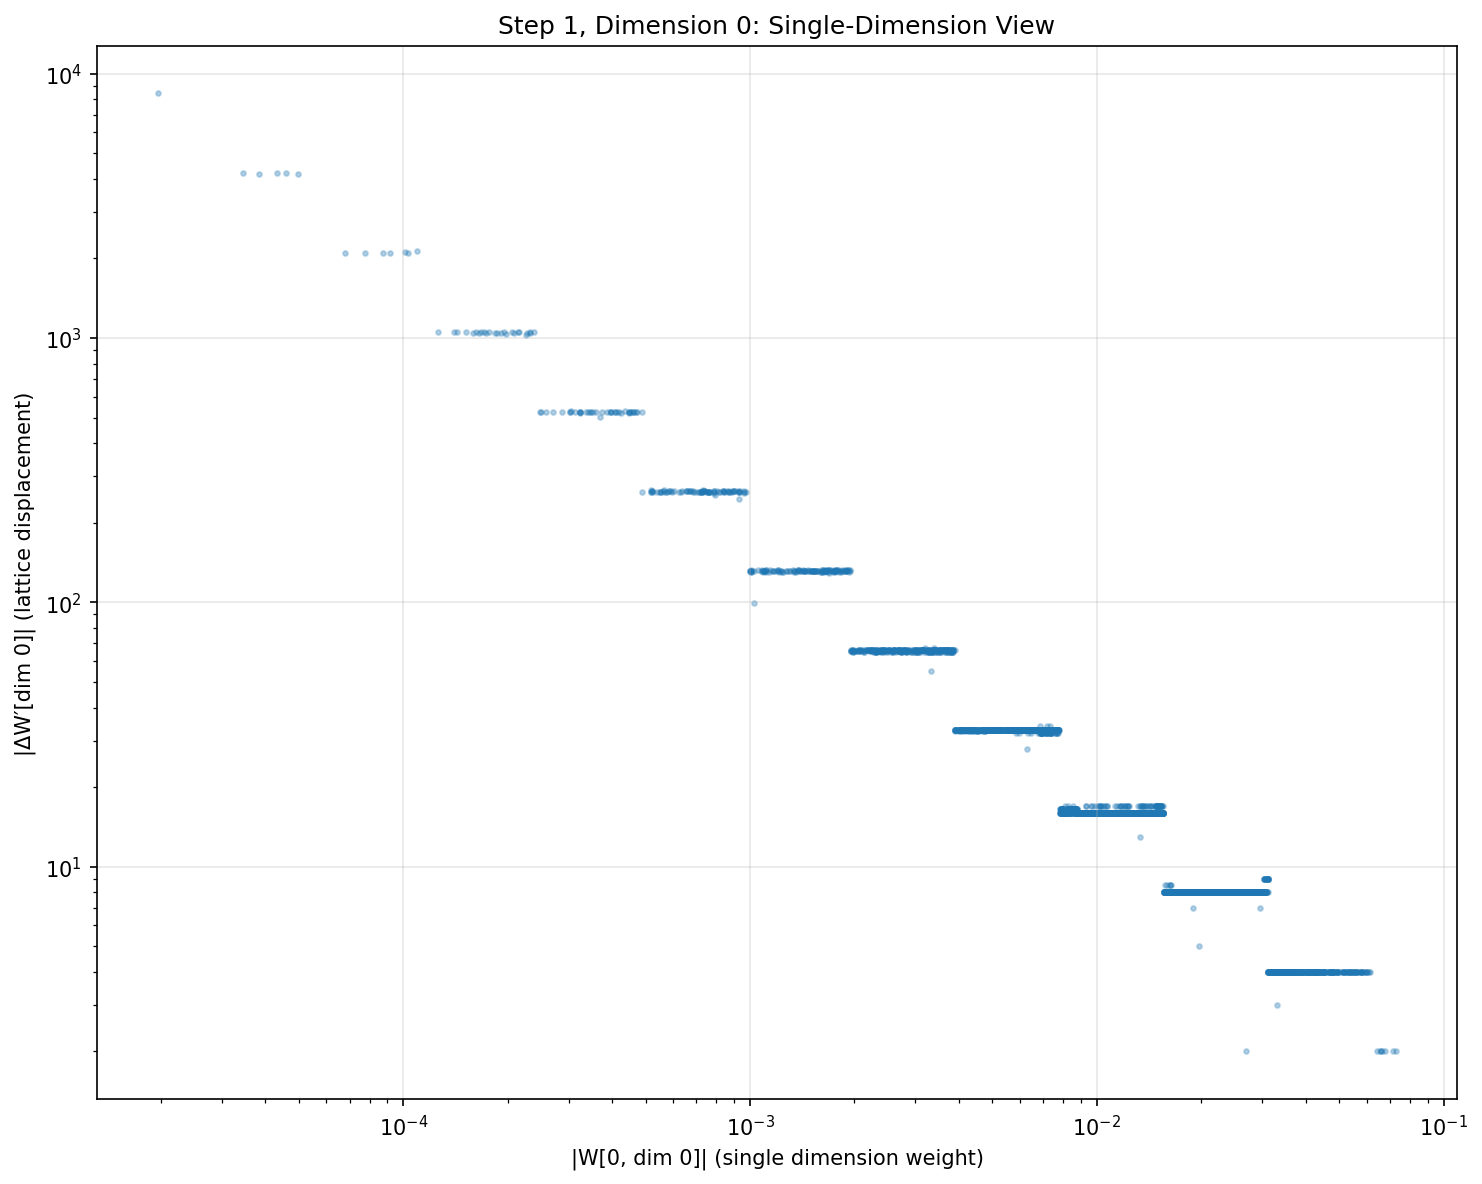

In [11]:
# The L2 aggregation is hiding the relationship. Let's look at a single dimension.
# Pick dimension 0 for all tokens.

dim_idx = 0

# Weight magnitude in dim 0
W_0_dim = torch.abs(W_0[:, dim_idx]).numpy()  # [3699]

# Displacement in dim 0 (in lattice units)
disp_dim = torch.abs(delta_W_prime[0, :, dim_idx]).numpy()  # [3699] step 1, dim 0

# Filter out zeros for log plot
mask = (W_0_dim > 0) & (disp_dim > 0) & np.isfinite(disp_dim)
W_masked = W_0_dim[mask]
disp_masked = disp_dim[mask]

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(W_masked, disp_masked, alpha=0.3, s=5)
ax.set_xlabel(f'|W[0, dim {dim_idx}]| (single dimension weight)')
ax.set_ylabel(f'|ΔW′[dim {dim_idx}]| (lattice displacement)')
ax.set_title(f'Step 1, Dimension {dim_idx}: Single-Dimension View')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Correlation in log space
log_corr_dim = np.corrcoef(np.log(W_masked), np.log(disp_masked))[0, 1]
print(f"Log-log correlation (dim {dim_idx}): {log_corr_dim:.4f}")

plt.tight_layout()
plt.show()

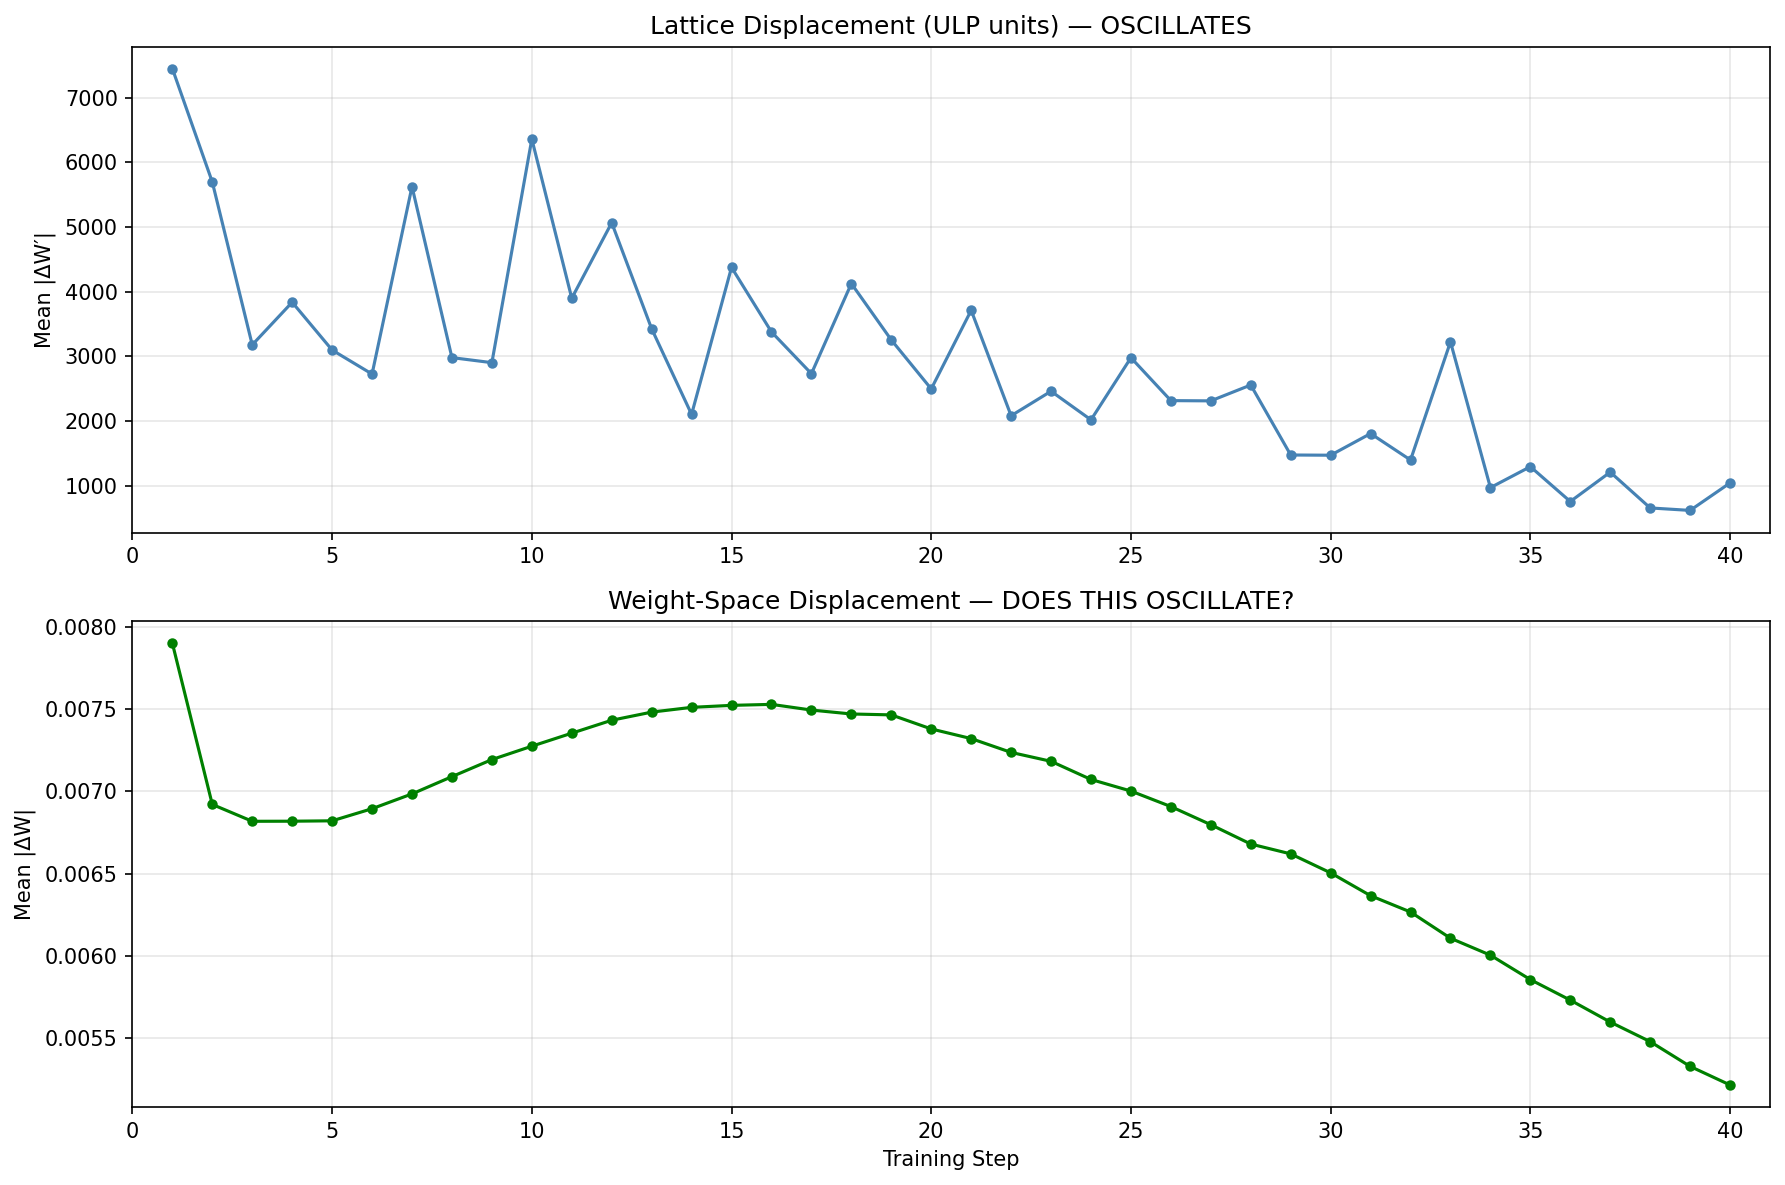

Correlation between |ΔW′| and |ΔW|: 0.6904


In [12]:
# CONCLUSION: The "oscillation" is a measurement artifact!
#
# To verify: let's compute actual weight-space displacement (ΔW, not ΔW′)
# and see if IT oscillates.

# ΔW = W[t+1] - W[t]
delta_W = W[1:N_STEPS+1] - W[:N_STEPS]  # [40, 3699, 64]
delta_W_l2 = delta_W.norm(dim=2)  # [40, 3699]
mean_delta_W = delta_W_l2.mean(dim=1).numpy()  # [40]

# Compare to lattice displacement
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

ax = axes[0]
ax.plot(steps, mean_disp, 'o-', color=STEELBLUE, markersize=4)
ax.set_ylabel('Mean |ΔW′|')
ax.set_title('Lattice Displacement (ULP units) — OSCILLATES')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, N_STEPS + 1)

ax = axes[1]
ax.plot(steps, mean_delta_W, 'o-', color='green', markersize=4)
ax.set_ylabel('Mean |ΔW|')
ax.set_title('Weight-Space Displacement — DOES THIS OSCILLATE?')
ax.set_xlabel('Training Step')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, N_STEPS + 1)

plt.tight_layout()
plt.show()

# Correlation between the two
print(f"Correlation between |ΔW′| and |ΔW|: {np.corrcoef(mean_disp, mean_delta_W)[0, 1]:.4f}")